# Hybrid Model (CNN and Transformer) - Convolutional Vision Transformer



In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils, Sequential
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

### Reading The Data

In [ ]:
!git clone https://github.com/nschultze/CS577Project.git

Cloning into 'CS577Project'...
remote: Enumerating objects: 2907, done.
remote: Counting objects: 100% (1111/1111), done.
remote: Compressing objects: 100% (1077/1077), done.
remote: Total 2907 (delta 51), reused 1086 (delta 33), pack-reused 1796
Receiving objects: 100% (2907/2907), 9.93 GiB | 36.67 MiB/s, done.
Resolving deltas: 100% (96/96), done.
Updating files: 100% (2715/2715), done.


In [ ]:
train_data_dir = 'CS577Project/train'
validation_data_dir = 'CS577Project/val'
test_data_dir = 'CS577Project/test'

#set the size of the image to be resized
target_size = (256, 256)

#using ImageDataGenerator for data augmentation and preprocessing (altering images to improve data variety)
datagen = ImageDataGenerator(
    rescale=1./255, #used to normalize the pixel values (dividing by max pixel value of 255)
    rotation_range=20, #randomly rotating the images by 20 degrees (almost like noise where we add variation)
    width_shift_range=0.2, #randomly shifting the images horizontally by 20 percent
    height_shift_range=0.2, #randomly shifting the images vertically by 20 percent
    shear_range=0.2, #setting the shear intensity to "stretch" the image
    zoom_range=0.2, #randomly zooming into the images by 20 percent
    horizontal_flip=True, #randomly flipping the images horizontally
    fill_mode='nearest') #because of the shifting, rotating, etc, there are missing pixels so we fill in those missing pixels with nearest valid values

#creating the generator for the training dataset
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size, #resizing
    batch_size=32,
    class_mode='binary') #binary for 2 labels

#creating the generator for the validation set
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary')

#creating the generator for the testing dataset
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary')

Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [ ]:
#Replicating CvT (Convolutional Vision Transformer)
#building the EfficientNetB0 model section (CNN section)
efficient_net = EfficientNetB0(include_top=False, input_shape=(256, 256, 3), weights='imagenet') #do not freeze the weights (want to train the weights more like transfer learning)

#input value with the target/altered size
inp = tf.keras.Input(shape=(256, 256, 3))

#building the CvT model
x = efficient_net(inp)
x = layers.Reshape((-1, 1280))(x) #resize to accommodate the output of efficient net
x = MultiHeadAttention(num_heads=4, key_dim=1280//4, dropout=0.1)(x, x) #adding the multi head attention to allow it to focus on different parts of the input
x = layers.GlobalAveragePooling1D()(x) #pooling to reduce input
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
#adding a batch normalization for regularization
x = layers.BatchNormalization()(x)
#final output is passed into single neuron using sigmoid (good for binary classification)
output = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inp, outputs=output)

#compiling the model with an initial lr of 1e-3 (will change as training)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
#used to change the learning rate as it is training
# reduces learning rate based on validation loss
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

#printing the model
model.summary()

#training the model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[lr_scheduler])  #adding the learning rate scheduler to change learning rate as it trains


#saving the model as a HDF5 file
model.save("cvt_model.h5")

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 8, 8, 1280)           4049571   ['input_2[0][0]']             
 )                                                                                                
                                                                                                  
 reshape (Reshape)           (None, 64, 1280)             0         ['efficientnetb0[0][0]']      
                                                                                                  
 multi_head_attention (Mult  

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


46/59 [======================>.......] - ETA: 4:05 - loss: 0.5045 - accuracy: 0.7845

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


59/59 [==============================] - 1296s 21s/step - loss: 0.4838 - accuracy: 0.7939 - val_loss: 0.6746 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 2/20
59/59 [==============================] - 1264s 21s/step - loss: 0.3618 - accuracy: 0.8574 - val_loss: 0.7013 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 3/20
59/59 [==============================] - 1258s 21s/step - loss: 0.2591 - accuracy: 0.9004 - val_loss: 0.7003 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 4/20
59/59 [==============================] - 1255s 21s/step - loss: 0.2383 - accuracy: 0.9083 - val_loss: 1.7307 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 5/20
59/59 [==============================] - 1254s 21s/step - loss: 0.1976 - accuracy: 0.9194 - val_loss: 1.7496 - val_accuracy: 0.6119 - lr: 2.0000e-04
Epoch 6/20
59/59 [==============================] - 1259s 21s/step - loss: 0.1532 - accuracy: 0.9438 - val_loss: 0.9370 - val_accuracy: 0.6169 - lr: 2.0000e-04
Epoch 7/20
59/59 [==============================] - 1258s 21s/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


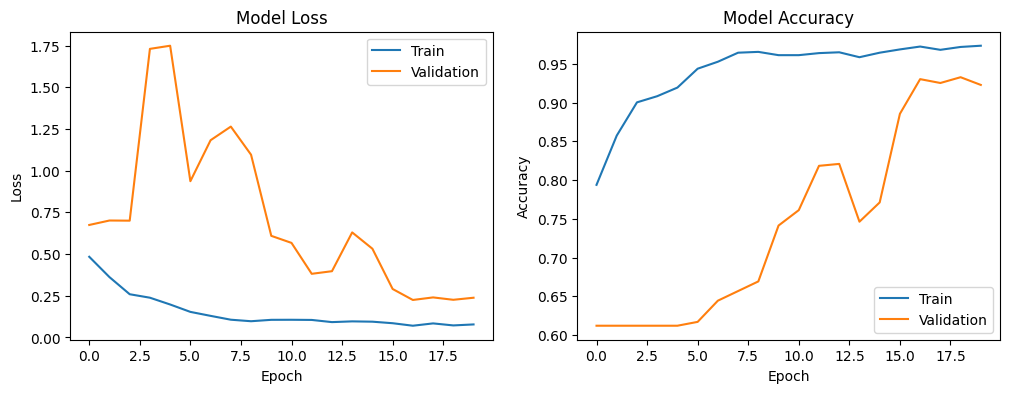

In [ ]:
#plotting the two figures of loss and accuracy
plt.figure(figsize=(12, 4))

#plotting the training & validation losses
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right') #placed at top right as loss should decrease as epochs increase

#plotting the training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right') #moved to lower right to not obstruct lines (acc should go upwards as epochs increase)

#saving the plots
plt.savefig("training_model_graphs.png")
plt.show()

In [ ]:
#evaluating the model on the testing set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc}')

#loading the model
loaded_model = tf.keras.models.load_model("cvt_model.h5")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 5/13 [==========>...................] - ETA: 1:46 - loss: 0.1573 - accuracy: 0.9438

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 7/13 [===============>..............] - ETA: 1:15 - loss: 0.1622 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


13/13 [==============================] - 158s 12s/step - loss: 0.1545 - accuracy: 0.9415
Test accuracy: 0.9414634108543396
